In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Load processed dataset produced by the preprocessing notebook
import os
processed_path = r'D:\\VS Codes\\Projects\\IPL-Score-Prediction-using-Deep-Learning-\\data\\processed\\model_data_processed.csv'
if not os.path.exists(processed_path):
    raise FileNotFoundError(f'Processed file not found: {processed_path}')
df = pd.read_csv(processed_path)
# Define features and target consistently with preprocessing notebook
features = ['batting_team_encoded', 'bowling_team_encoded', 'venue_encoded', 'current_score', 'wickets_fallen', 'overs']
target = 'final_total_score'
# Build training arrays
X_raw = df[features].values
y_raw = df[[target]].values.squeeze()
# Recreate/fit scaler here so this notebook can run standalone
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
print('Loaded processed data:', X_scaled.shape, y_raw.shape)

Loaded processed data: (69587, 6) (69587,)


In [3]:
# Convert the arrays we created in the cleaning step
tensor_x = torch.Tensor(X_scaled)
tensor_y = torch.Tensor(y_raw)

# Create DataLoader (Batch Size 64 is good for per-over data)
dataset = TensorDataset(tensor_x, tensor_y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [4]:
class MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gaussians):
        super(MDN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim) # Added extra layer for depth
        
        self.pi = nn.Linear(hidden_dim, num_gaussians)
        self.sigma = nn.Linear(hidden_dim, num_gaussians)
        self.mu = nn.Linear(hidden_dim, num_gaussians)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        pi = F.softmax(self.pi(x), dim=1)
        sigma = torch.exp(self.sigma(x)) # Sigma must be positive
        mu = self.mu(x)
        return pi, sigma, mu

def mdn_loss(pi, sigma, mu, y):
    y = y.unsqueeze(1).expand_as(mu)  # Ensure shape matches (batch, num_gaussians)
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    probs = torch.exp(m.log_prob(y))
    weighted_probs = torch.sum(pi * probs, dim=1)
    nll = -torch.log(weighted_probs + 1e-6)
    return torch.mean(nll)

In [5]:
# Config
INPUT_DIM = 6   # (Teams, Venue, Score, Wickets, Overs)
HIDDEN_DIM = 128
NUM_GAUSSIANS = 3 # Modes: Collapse, Average, Slog
EPOCHS = 100    # Short enough for quick results
LR = 0.002

model = MDN(INPUT_DIM, HIDDEN_DIM, NUM_GAUSSIANS)
optimizer = optim.Adam(model.parameters(), lr=LR)

print("🚀 Starting Training...")
losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    for bx, by in dataloader:
        optimizer.zero_grad()
        pi, sigma, mu = model(bx)
        loss = mdn_loss(pi, sigma, mu, by)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

🚀 Starting Training...
Epoch 10/100 | Loss: 4.1865
Epoch 10/100 | Loss: 4.1865
Epoch 20/100 | Loss: 3.9830
Epoch 20/100 | Loss: 3.9830
Epoch 30/100 | Loss: 3.7616
Epoch 30/100 | Loss: 3.7616
Epoch 40/100 | Loss: 3.6081
Epoch 40/100 | Loss: 3.6081
Epoch 50/100 | Loss: 3.4955
Epoch 50/100 | Loss: 3.4955
Epoch 60/100 | Loss: 3.4177
Epoch 60/100 | Loss: 3.4177
Epoch 70/100 | Loss: 3.3501
Epoch 70/100 | Loss: 3.3501
Epoch 80/100 | Loss: 3.2960
Epoch 80/100 | Loss: 3.2960
Epoch 90/100 | Loss: 3.2413
Epoch 90/100 | Loss: 3.2413
Epoch 100/100 | Loss: 3.1946
Epoch 100/100 | Loss: 3.1946


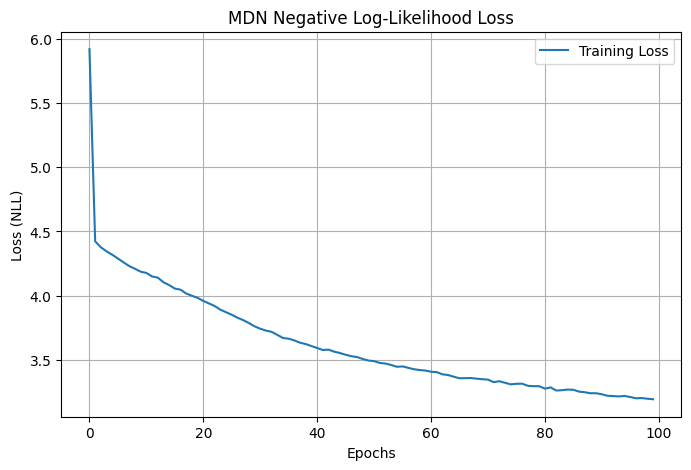

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.title('MDN Negative Log-Likelihood Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (NLL)')
plt.legend()
plt.grid(True)
plt.show()


📊 Generating PPT Graph...


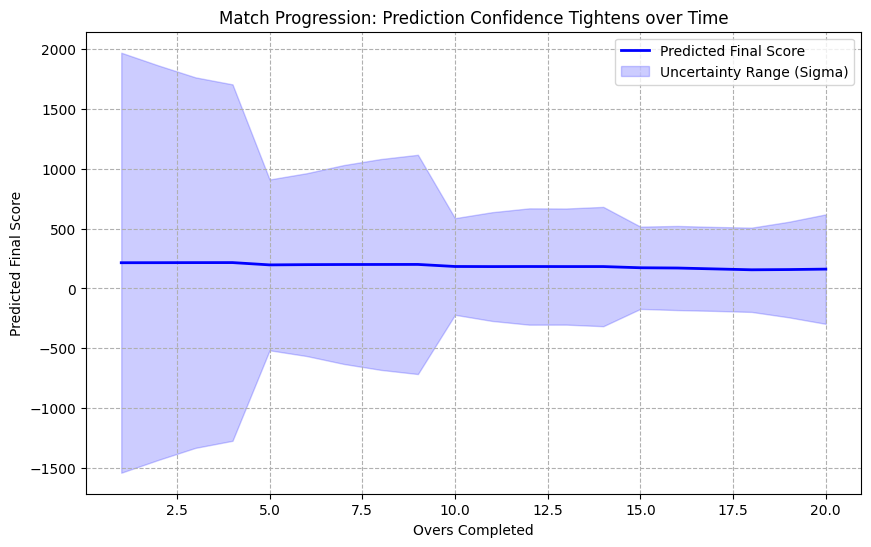

In [7]:
# We simulate a "Fake Match" to see how prediction changes over overs
def plot_uncertainty_cone():
    model.eval()
    
    # Create a hypothetical match progression: 
    # Team scores 8 runs per over, loses 1 wicket every 5 overs
    overs = np.arange(1, 21)
    runs = overs * 8 
    wickets = np.floor(overs / 5) 
    
    # We need to scale these hypothetical inputs just like training data
    # We create a dummy matrix matching the feature structure
    # [BatTeam, BowlTeam, Venue, CurrentScore, Wickets, Overs]
    # We'll just use 0, 1, 0 for teams/venue (fixed)
    dummy_input = np.zeros((20, 6))
    dummy_input[:, 0] = 0 # Team A
    dummy_input[:, 1] = 1 # Team B
    dummy_input[:, 2] = 0 # Venue
    dummy_input[:, 3] = runs
    dummy_input[:, 4] = wickets
    dummy_input[:, 5] = overs
    
    # Scale it using the scaler we trained on
    scaled_input = scaler_X.transform(dummy_input)
    tensor_input = torch.Tensor(scaled_input)
    
    # Predict
    with torch.no_grad():
        pi, sigma, mu = model(tensor_input)
    
    # Calculate Weighted Mean and Weighted Std Dev
    # (Simplified for visualization)
    predicted_means = torch.sum(pi * mu, dim=1).numpy()
    
    # For uncertainty, we take the largest sigma (worst case variance)
    # This is a simplification for plotting the "cone"
    uncertainties = torch.max(sigma, dim=1)[0].numpy()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(overs, predicted_means, color='blue', linewidth=2, label='Predicted Final Score')
    
    # The "Cone" of uncertainty
    plt.fill_between(overs, 
                     predicted_means - uncertainties, 
                     predicted_means + uncertainties, 
                     color='blue', alpha=0.2, label='Uncertainty Range (Sigma)')
    
    plt.title('Match Progression: Prediction Confidence Tightens over Time')
    plt.xlabel('Overs Completed')
    plt.ylabel('Predicted Final Score')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

print("\n📊 Generating PPT Graph...")
plot_uncertainty_cone()

In [10]:
def predict_future_match(batting_team, bowling_team, venue, current_score, wickets, overs):
    model.eval() # Set model to evaluation mode
    
    # 1. Encode the Strings (Team Names -> Numbers)
    try:
        bat_enc = le_teams.transform([batting_team])[0]
        bowl_enc = le_teams.transform([bowling_team])[0]
        venue_enc = le_venue.transform([venue])[0]
    except ValueError:
        print("❌ Error: Team or Venue name not found in training data. Check spelling!")
        return

    # 2. Prepare the Input Array [Bat, Bowl, Venue, Score, Wickets, Overs]
    input_data = np.array([[bat_enc, bowl_enc, venue_enc, current_score, wickets, overs]])
    
    # 3. Scale the Input (Crucial! We must use the SAME scaler from training)
    input_scaled = scaler_X.transform(input_data)
    tensor_input = torch.Tensor(input_scaled)
    
    # 4. Get Prediction from MDN
    with torch.no_grad():
        pi, sigma, mu = model(tensor_input)
    
    # 5. Calculate the Weighted Average (The "Single Number" Prediction)
    # Formula: Sum(Probability * Mean)
    predicted_score = torch.sum(pi * mu).item()
    
    # 6. Get the Uncertainty (Standard Deviation)
    # We take the sigma associated with the highest probability mode
    max_prob_index = torch.argmax(pi)
    uncertainty = sigma[0][max_prob_index].item()
    
    print(f"------------------------------------------------")
    print(f"🏏 Match: {batting_team} vs {bowling_team} at {venue}")
    print(f"📊 Situation: {current_score}/{wickets} in {overs} overs")
    print(f"------------------------------------------------")
    print(f"🔮 PREDICTED FINAL SCORE: {int(predicted_score)}")
    print(f"📉 Range: {int(predicted_score - uncertainty)} to {int(predicted_score + uncertainty)}")
    print(f"------------------------------------------------")
    
    return predicted_score

In [11]:
# --- EXAMPLE USAGE ---
# Change these values to test different scenarios
predict_future_match(
    batting_team='Chennai Super Kings', 
    bowling_team='Mumbai Indians', 
    venue='Wankhede Stadium, Mumbai', 
    current_score=85, 
    wickets=2, 
    overs=10
)

NameError: name 'le_teams' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_model(dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for bx, by in dataloader:
            pi, sigma, mu = model(bx)
            
            # Calculate weighted mean prediction for each row in batch
            weighted_mu = torch.sum(pi * mu, dim=1)
            
            y_true.extend(by.numpy().flatten())
            y_pred.extend(weighted_mu.numpy().flatten())
            
    # Calculate Metrics
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"✅ MODEL EVALUATION RESULTS:")
    print(f"Mean Absolute Error (MAE): {mae:.2f} runs")
    print(f"R-Squared Score (R2): {r2:.4f}")
    
    # Plot Actual vs Predicted (For PPT)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.3, color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Ideal line
    plt.xlabel("Actual Score")
    plt.ylabel("Predicted Score")
    plt.title(f"Prediction Accuracy (MAE: {mae:.2f})")
    plt.grid(True)
    plt.show()

# Run the evaluation
evaluate_model(dataloader)